## A sentiment analysis on tweets related to E-levy.

#### This project seems to analyze the general consensus on the introduction of e-levy (electronic levy) charges by the Ghana Government on digital transactions. 

It uses the ------ NLP model to analyze the sentiments of hundreds of tweets scraped from twitter.

Importing first libraries <br>
<ul>
<li>snscrape ---> a scraper for social networking services </li>
<li>pandas ---> an open source data analysis and manipulation tool </li> 
<li>re ---> library for string manipulation</li>
</ul>

In [195]:
import snscrape.modules.twitter as sntwitter
import pandas as pd
import itertools
import re
import preprocessor as p


import nltk
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize

lemmatizer = nltk.stem.WordNetLemmatizer()
stop_words = set(stopwords.words('english'))



[nltk_data] Downloading package wordnet to C:\Users\Innocent
[nltk_data]     Anyaele\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Innocent
[nltk_data]     Anyaele\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


we build our query here by gathering e-levy related tweets from when it was first announced (2022/09/20)
we ran the query for may, june, july, august
we store our gathered tweets in a csv file -> streams.csv

In [283]:
def scrapeTweets(query, file):        
    
    tweets = []
    limit = 200

    data = sntwitter.TwitterSearchScraper(query).get_items()
    print (data.__sizeof__)
    for tweet in data:
        if len(tweets) == limit:
            break
        else:
            tweet_text = tweet.content
            tweets.append([tweet.id, tweet_text, tweet.date])
            
    df = pd.DataFrame(tweets, columns=['id', 'Tweet', 'Date'])

    df.to_csv(file, index=False, columns=['id','Tweet','Date'])
    
    
may_query = "e-levy near:'Accra' lang:en until:2022-05-31 since:2022-05-01 -filter:links"  # may
june_query = "e-levy near:'Accra' lang:en until:2022-06-30 since:2022-06-01 -filter:links"  # june
july_query = "e-levy near:'Accra' lang:en until:2022-07-31 since:2022-07-01 -filter:links"  # july
august_query = "e-levy near:'Accra' lang:en until:2022-08-31 since:2022-08-01 -filter:links"  # august

scrapeTweets(may_query, 'may.csv')
scrapeTweets(june_query, 'june.csv')
scrapeTweets(july_query, 'july.csv')
scrapeTweets(august_query, 'august.csv')

<built-in method __sizeof__ of generator object at 0x000001AE334B1B30>
<built-in method __sizeof__ of generator object at 0x000001AE334B1D60>
<built-in method __sizeof__ of generator object at 0x000001AE3348AE40>
<built-in method __sizeof__ of generator object at 0x000001AE3348AA50>


Our tweet containes 200 rows each for four months -> 800, each row containing the tweet id, tweet content and the tweet date.
We print the first 5 tweets
We see our tweets, contains a lot of unneccessary data for analysis, so we preprocess it in the next step

In [284]:
may_df = pd.read_csv('may.csv')
june_df = pd.read_csv('june.csv')
july_df = pd.read_csv('july.csv')
august_df = pd.read_csv('august.csv')

df = pd.concat([may_df,june_df,july_df,august_df], axis=0)

print(df.shape)
print(df['Tweet'].head(5))

(800, 3)
0    @JoyNewsOnTV He’s a liar, cuz they’re having m...
1    @JoyNewsOnTV The only illegal thing here is th...
2    For Christ sake the war between Ukraine and Ru...
3                @fatsinyi I never paid e-levy. 🙏🏾🙏🏾🙏🏾
4    @adb_Ghana How does adb deduct e-levy on faile...
Name: Tweet, dtype: object


The preprocessing stage involves cleaning up our tweets with a regex function by removing links, tags and whitespaces.

We also leverage the NLTK library to remove stop words such as "and", "or", "in"

After we print some of our tweets, it looks much more cleaner than before

In [285]:
def tweet_preprocessing(tweet):
    # regex cleanup
    tweet = re.sub(r"^https://t.co/[A-Za-z0-9]*\s", " ", tweet)
    tweet = re.sub(r"\s+https://t.co/[a-zA-Z0-9]*\s", " ", tweet)
    tweet = re.sub(r"\s+https://t.co/[a-zA-Z0-9]*$", " ", tweet)
    tweet = re.sub("\.\.+", " ", tweet)
    tweet = re.sub("-$", "", tweet)
    tweet = re.sub(r'[^\w\s]', '', tweet)
    tweet = re.sub(r"^ +", "", tweet)
    tweet = re.sub(r"  +", " ", tweet)
    
    # use preprocessing library to clean
    tweet = p.clean(tweet)
    tweet = tweet.lower()
    
    # tokenize
    token_tweet = word_tokenize(tweet)
    filtered = [w for w in token_tweet if not w.lower() in stop_words]
    filtered_array  = []
    
    # remove stopwords
    for w in token_tweet:
        if w not in stop_words:
            filtered_array.append(w)
                 
    
    return ' '.join(filtered_array)


# applying our pre processing function to our tweet
df['Tweet'] = df['Tweet'].apply(lambda x: tweet_preprocessing(x))
print (df['Tweet'].tail(5)) 


195    kojowusu12 sulemana leaders serve interest vot...
196                 kwabenalovesama elevy dey everywhere
197    anfieldogyiri sulemana lazy thoughtless elevyy...
198    ohemaa__ imobeng91444331 go tear vat elevy res...
199    joy997fm know even one lying chopping necessar...
Name: Tweet, dtype: object


##### Using the BERT Model

The BERT Model is a transformer based machine learning technique for natural language processing pre-training developed by Google. -> Wikipedia

We import the AutoTokenizer and the AutoModel for Sequence Classification

In [286]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')


We import Torch (an open source machine learning framework that can be used for natural language processing) and create a function that will leverage our tokenizer and model to find the sentiment score of a particular tweet. The score will return an array of scores will be computed on using torch.argmax function to find the appropriate sentiment score.

The score will fall in the range 1 - 3.
1 being negative sentiment and 3 being position sentiment with 2 a neutral sentiment.

Let's try this function on the text "I hate this" to test our model.

It returns 1 (a negative sentiment).

We try function on the text "I love this".

It returns a 3 (a positive sentiment)



In [287]:
import torch

def sentiment_score(tweet):
    tokens = tokenizer.encode(tweet, return_tensors='pt')
    result = model(tokens)
    result.logits
    # print (result.logits)
    return (int(torch.argmax(result.logits))+1)

sentiment_score('I hate this')
# sentiment_score('i love this')

1

We apply our sentiment score function on a newly created column called sentiment score 

In [288]:
df['sentiment_score'] = df['Tweet'].apply(lambda x: sentiment_score(x)) 

In [289]:
df.tail(10)

,id,Tweet,Date,sentiment_score
190,1562539421689253889,sulemana violently opposing elevy spreading op...,2022-08-24 20:36:43+00:00,1
191,1562530854475563014,lol worked bank ghana money mbawumia stealing ...,2022-08-24 20:02:40+00:00,1
192,1562530572601155584,especially worse nowadays dont keep money momo...,2022-08-24 20:01:33+00:00,1
193,1562530353738223616,hatekahshine sulemana programed government bot...,2022-08-24 20:00:41+00:00,1
194,1562529986854080514,kojowusu12 sulemana patriotism nothing elevy g...,2022-08-24 19:59:13+00:00,1
195,1562521276781961217,kojowusu12 sulemana leaders serve interest vot...,2022-08-24 19:24:37+00:00,1
196,1562520616883802112,kwabenalovesama elevy dey everywhere,2022-08-24 19:21:59+00:00,5
197,1562520562484023296,anfieldogyiri sulemana lazy thoughtless elevyy...,2022-08-24 19:21:46+00:00,1
198,1562516765757751296,ohemaa__ imobeng91444331 go tear vat elevy res...,2022-08-24 19:06:41+00:00,1
199,1562516559683555329,joy997fm know even one lying chopping necessar...,2022-08-24 19:05:52+00:00,1


We add a newly created column with the text equivalent of our score.
1 - negative
2 - neutral
3 - positive

In [291]:
def get_sentiment(x):
    if x == 1:
        return 'Very Negative'
    if x == 2:
        return 'Negative'
    if x == 3:
        return "Neutrial"
    if x == 4:
        return  "Positive"
    if x == 5:
        return "Very Positive"
    
df['sentiment'] = df['sentiment_score'].apply(lambda x: get_sentiment(x))

df['sentiment'].tail(10)

190    Very Negative
191    Very Negative
192    Very Negative
193    Very Negative
194    Very Negative
195    Very Negative
196    Very Positive
197    Very Negative
198    Very Negative
199    Very Negative
Name: sentiment, dtype: object

We seperate our dataset results now into the four different months so we can perform some analysis


In [343]:
import datetime

may_df = df[(df['Date'] > datetime.datetime(2022, 4, 30, 00, 0, tzinfo=datetime.timezone.utc)) & (
    (df['Date'] < datetime.datetime(2022, 6, 1, 00, 0, tzinfo=datetime.timezone.utc)))]
june_df = df[(df['Date'] > datetime.datetime(2022, 5, 31, 00, 0, tzinfo=datetime.timezone.utc)) & (
    (df['Date'] < datetime.datetime(2022, 7, 1, 00, 0, tzinfo=datetime.timezone.utc)))]
july_df = df[(df['Date'] > datetime.datetime(2022, 6, 30, 00, 0, tzinfo=datetime.timezone.utc)) & (
    (df['Date'] < datetime.datetime(2022, 8, 1, 00, 0, tzinfo=datetime.timezone.utc)))]
august_df = df[(df['Date'] > datetime.datetime(2022, 7, 31, 00, 0, tzinfo=datetime.timezone.utc)) & (
    (df['Date'] < datetime.datetime(2022, 9, 1, 00, 0, tzinfo=datetime.timezone.utc)))]

print('total tweet sentiment score description \n',
      '--------------------------------------\n', df['sentiment_score'].describe(), '\n')
print('may tweet sentiment score description \n',
      '--------------------------------------\n', may_df['sentiment_score'].describe(), '\n')
print('june tweet sentiment score description \n',
      '--------------------------------------\n', june_df['sentiment_score'].describe(), '\n')
print('july tweet sentiment score description \n',
      '--------------------------------------\n', july_df['sentiment_score'].describe(), '\n')
print('august tweet sentiment score description \n',
      '--------------------------------------\n', august_df['sentiment_score'].describe(), '\n')


total tweet sentiment score description 
 --------------------------------------
 count    800.000000
mean       1.808750
std        1.487427
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        5.000000
Name: sentiment_score, dtype: float64 

may tweet sentiment score description 
 --------------------------------------
 count    200.000000
mean       1.945000
std        1.592058
min        1.000000
25%        1.000000
50%        1.000000
75%        3.000000
max        5.000000
Name: sentiment_score, dtype: float64 

june tweet sentiment score description 
 --------------------------------------
 count    200.000000
mean       1.730000
std        1.427335
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        5.000000
Name: sentiment_score, dtype: float64 

july tweet sentiment score description 
 --------------------------------------
 count    200.000000
mean       1.730000
std        1.416734
min        1.000

Our sentiment count, 
very negative  = 780
negative = 24
neutral = 86
positive = 21
very positive = 189


In [292]:
sentiment_count = (df['sentiment'].value_counts())
sentiment_count = pd.DataFrame({'Sentiments' : sentiment_count.values, 'Count': sentiment_count.index})
print (sentiment_count)

   Sentiments          Count
0         599  Very Negative
1         117  Very Positive
2          45       Neutrial
3          25       Positive
4          14       Negative


Below is a chart of our total sentiment count plot. Out of the hundreds of tweets collected for the past 4 months;
<ul>
<li> Very Negative - 599 </li>
<li> Negative - 14 </li>
<li> Neutral - 45 </li>
<li> Positive - 25 </li>
<li> Very Positive - 117 </li>
</ul>


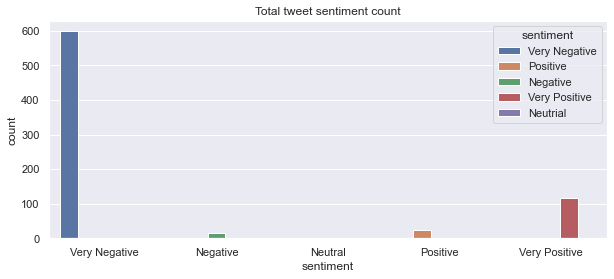

In [351]:
import seaborn as sns
sns.set(rc={"figure.figsize": (10, 4)})
sentiment_count_chart = sns.countplot(x='sentiment', data=df, hue='sentiment', order = ['Very Negative', 'Negative', 'Neutral', 'Positive', 'Very Positive'])
sentiment_count_chart.set(title='Total tweet sentiment count')
sentiment_count_chart.get_figure().savefig('sentiment_count_chart.png')


Our May tweets sentiment counts

Very Negative    143
Very Positive     36
Neutrial          10
Positive           7
Negative           4
Name: sentiment, dtype: int64


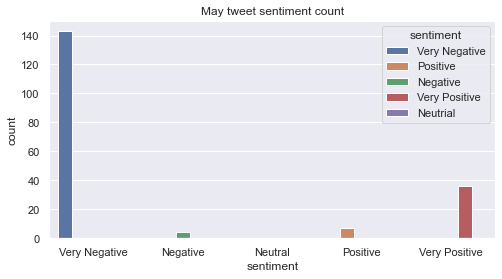

In [357]:
print(may_df['sentiment'].value_counts())
may_count = sns.countplot(x='sentiment', data=may_df, hue='sentiment', order=['Very Negative', 'Negative', 'Neutral', 'Positive', 'Very Positive'])
may_count.set(title = 'May tweet sentiment count')
may_count.get_figure().savefig('may_count.png')

Our June tweets sentiment count

Very Negative    154
Very Positive     25
Neutrial           9
Positive           8
Negative           4
Name: sentiment, dtype: int64


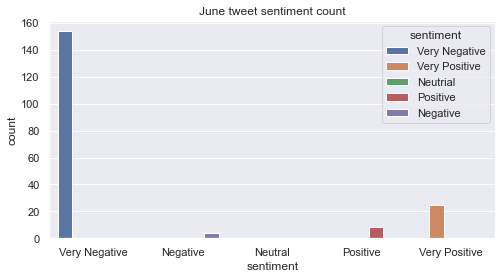

In [358]:
print(june_df['sentiment'].value_counts())
june_count = sns.countplot(x='sentiment', data=june_df, hue='sentiment', order=['Very Negative', 'Negative', 'Neutral', 'Positive', 'Very Positive'])
june_count.set(title = 'June tweet sentiment count')
june_count.get_figure().savefig('june_count.png')

Our July tweets sentiment count

Very Negative    153
Very Positive     25
Neutrial          12
Positive           6
Negative           4
Name: sentiment, dtype: int64


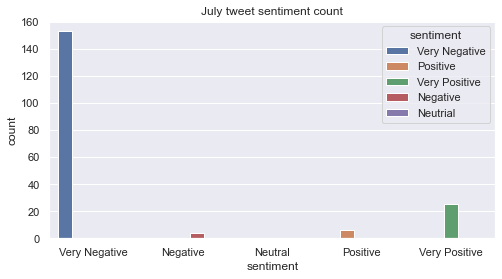

In [359]:
print(july_df['sentiment'].value_counts())
july_count = sns.countplot(x='sentiment', data=july_df, hue='sentiment', order=['Very Negative', 'Negative', 'Neutral', 'Positive', 'Very Positive'])
july_count.set(title = 'July tweet sentiment count')
july_count.get_figure().savefig('july_count.png')

Our July tweets sentiment count

Very Negative    149
Very Positive     31
Neutrial          14
Positive           4
Negative           2
Name: sentiment, dtype: int64


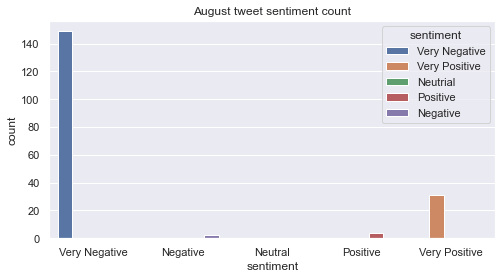

In [360]:
print(august_df['sentiment'].value_counts())
august_count = sns.countplot(x='sentiment', data=august_df, hue='sentiment', order=[
                           'Very Negative', 'Negative', 'Neutral', 'Positive', 'Very Positive'])
august_count.set(title='August tweet sentiment count')
august_count.get_figure().savefig('august_count.png')


In [264]:
df.to_csv('full.csv', index=False, columns=['id', 'Tweet', 'Date', 'sentiment_score', 'sentiment'])